# 03 Mask Sensitivity

Study how RISE mask count `N` affects compute time and explanation quality on one image.

## Protocol
- Fix one image and model.
- Measure runtime for each `N` (several repeats).
- Quality proxy 1: similarity to a high-mask reference map (`N_ref`).
- Quality proxy 2: insertion/deletion AUC trends versus `N`.

In [5]:
import os
%cd "C:\Users\titou\OneDrive\Bureau\mva\xai"

print(os.getcwd())


C:\Users\titou\OneDrive\Bureau\mva\xai
C:\Users\titou\OneDrive\Bureau\mva\xai


In [10]:
print(os.getcwd())

C:\Users\titou\OneDrive\Bureau\mva\xai\xaif


In [6]:
from time import perf_counter
from sklearn.metrics import auc

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from torchvision.datasets import ImageFolder
import torch

from xaif.scripts.tools_for_data.data import image_to_tensor
from xaif.scripts.models.gradcam import compute_gradcam
from xaif.scripts.models.rise import compute_rise_saliency
from xaif.scripts.metrics.deletion import deletion_curve
from xaif.scripts.metrics.insertion import insertion_curve
from xaif.scripts.models.reset import get_resnet50, predict_class


In [9]:
%cd xaif/
# If notebook runs from xaif/notebooks, move to xaif root for clean relative paths
project_root = Path.cwd().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent

data_root = project_root / 'data' / 'imagenette-320' / 'val'
labels_path = project_root / 'data' / 'imagenet_labels.json'

with open(labels_path, "r", encoding="utf-8") as f:
    imagenet_labels = json.load(f)



dataset = ImageFolder(str(data_root))
sample_index = 1505  # <-- change this index
steps = 20
num_masks = 2000
device = 'cpu'  # or 'cuda'

image_path, _ = dataset.samples[sample_index]
image_path = Path(image_path)




model = get_resnet50(device=device)
inp = image_to_tensor(image_path, image_size=224, device=device)
pred_class = predict_class(model, inp)
image_chw = inp[0].detach().cpu()


pred_class = predict_class(model, inp)
print(pred_class)
label = imagenet_labels[pred_class]
print(label)
safe_label = label.replace(" ", "_")

out_dir = project_root / 'outputs' / f'{safe_label}_{sample_index:04d}' / 'eval'
out_dir.mkdir(parents=True, exist_ok=True)


[WinError 2] Le fichier spécifié est introuvable: 'xaif/'
C:\Users\titou\OneDrive\Bureau\mva\xai\xaif


c:\Users\titou\miniforge3\envs\amande\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\titou\miniforge3\envs\amande\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


491
chain saw


RISE: 100%|██████████| 5000/5000 [07:59<00:00, 10.44it/s]


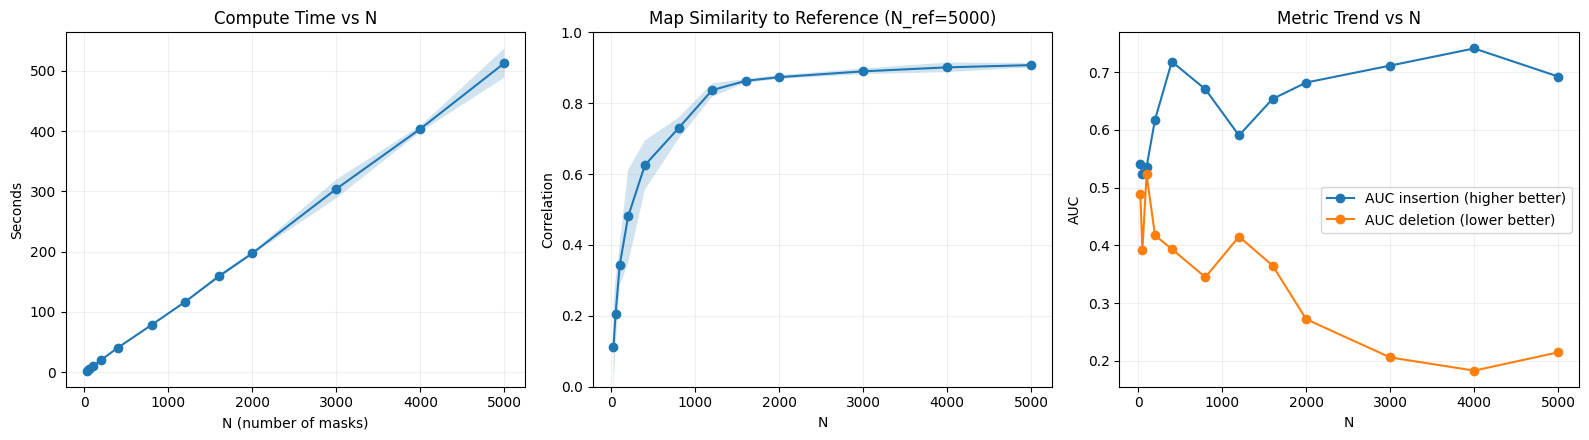

Saved summary figure to: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chain_saw_1505\eval\n_sensitivity_summary.png


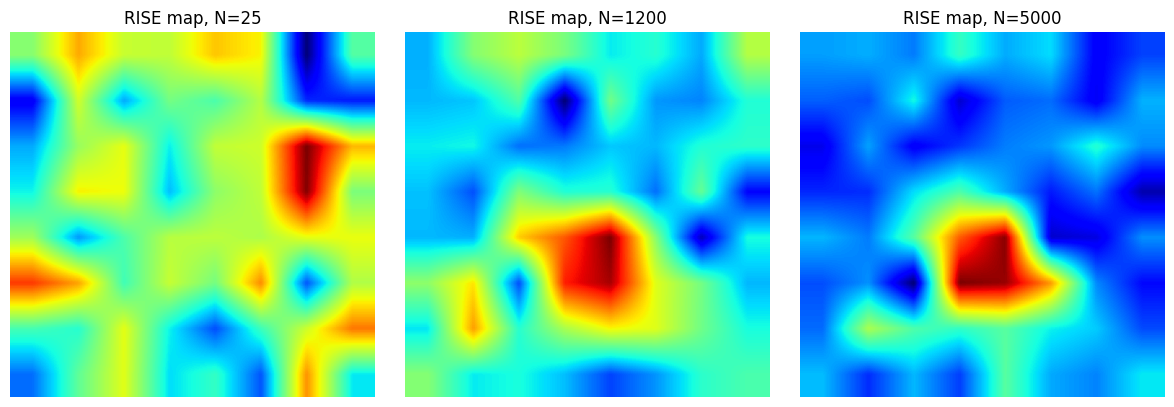

Saved map panel to: C:\Users\titou\OneDrive\Bureau\mva\xai\xaif\outputs\chain_saw_1505\eval\rise_maps_small_mid_large.png


In [14]:
# -------------------------------------------------
# Parameters
# -------------------------------------------------
N_values = [25, 50, 100, 200, 400, 800, 1200, 1600, 2000, 3000, 4000, 5000]
repeats = 3
N_ref = 5000
metric_steps = 20

np.random.seed(2026)
torch.manual_seed(2026)

# -------------------------------------------------
# Compute reference RISE saliency map
# -------------------------------------------------
ref_map = compute_rise_saliency(
    model=model,
    input_tensor=inp,
    pred_class=pred_class,
    N=N_ref,
    s=8,
    p1=0.5,
)

# -------------------------------------------------
# Helper function: correlation
# -------------------------------------------------
def corr(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    a = a - a.mean()
    b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float(np.dot(a, b) / denom)

# -------------------------------------------------
# Run experiments for different N
# -------------------------------------------------
records = []
maps_for_auc = {}

for N in N_values:
    times = []
    sims = []
    first_map = None
    for r in range(repeats):
        seed = 1000 + r
        np.random.seed(seed)
        torch.manual_seed(seed)

        t0 = perf_counter()
        sal = compute_rise_saliency(
            model=model,
            input_tensor=inp,
            pred_class=pred_class,
            N=N,
            s=8,
            p1=0.5,
        )
        t1 = perf_counter()

        times.append(t1 - t0)
        sims.append(corr(sal, ref_map))
        if first_map is None:
            first_map = sal

    maps_for_auc[N] = first_map
    records.append({
        "N": N,
        "time_mean": float(np.mean(times)),
        "time_std": float(np.std(times)),
        "sim_mean": float(np.mean(sims)),
        "sim_std": float(np.std(sims)),
    })

# -------------------------------------------------
# Compute AUC metrics
# -------------------------------------------------
for rec in records:
    N = rec["N"]
    sal = maps_for_auc[N]
    del_curve = deletion_curve(model, image_chw, sal, pred_class, steps=metric_steps, device=device)
    ins_curve = insertion_curve(model, image_chw, sal, pred_class, steps=metric_steps, device=device)
    x = np.linspace(0, 1, metric_steps)
    rec["auc_del"] = float(auc(x, del_curve))
    rec["auc_ins"] = float(auc(x, ins_curve))

# -------------------------------------------------
# Extract arrays for plotting
# -------------------------------------------------
N = np.array([r["N"] for r in records])
time_mean = np.array([r["time_mean"] for r in records])
time_std = np.array([r["time_std"] for r in records])
sim_mean = np.array([r["sim_mean"] for r in records])
sim_std = np.array([r["sim_std"] for r in records])
auc_del = np.array([r["auc_del"] for r in records])
auc_ins = np.array([r["auc_ins"] for r in records])

# -------------------------------------------------
# Plot summary figure
# -------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Compute time
axes[0].plot(N, time_mean, marker="o")
axes[0].fill_between(N, time_mean - time_std, time_mean + time_std, alpha=0.2)
axes[0].set_title("Compute Time vs N")
axes[0].set_xlabel("N (number of masks)")
axes[0].set_ylabel("Seconds")
axes[0].grid(alpha=0.2)

# Similarity to reference
axes[1].plot(N, sim_mean, marker="o")
axes[1].fill_between(N, sim_mean - sim_std, sim_mean + sim_std, alpha=0.2)
axes[1].set_title(f"Map Similarity to Reference (N_ref={N_ref})")
axes[1].set_xlabel("N")
axes[1].set_ylabel("Correlation")
axes[1].set_ylim(0, 1.0)
axes[1].grid(alpha=0.2)

# AUC metrics
axes[2].plot(N, auc_ins, marker="o", label="AUC insertion (higher better)")
axes[2].plot(N, auc_del, marker="o", label="AUC deletion (lower better)")
axes[2].set_title("Metric Trend vs N")
axes[2].set_xlabel("N")
axes[2].set_ylabel("AUC")
axes[2].grid(alpha=0.2)
axes[2].legend()

plt.tight_layout()
summary_path = out_dir / "n_sensitivity_summary.png"
fig.savefig(summary_path, dpi=150)
plt.show()
print("Saved summary figure to:", summary_path)

# -------------------------------------------------
# Plot example RISE maps
# -------------------------------------------------
example_N = [N_values[0], N_values[len(N_values)//2], N_values[-1]]
fig, axes = plt.subplots(1, len(example_N), figsize=(12, 4))
for ax, N_i in zip(axes, example_N):
    ax.imshow(maps_for_auc[N_i], cmap="jet")
    ax.set_title(f"RISE map, N={N_i}")
    ax.axis("off")

plt.tight_layout()
maps_path = out_dir / "rise_maps_small_mid_large.png"
fig.savefig(maps_path, dpi=150)
plt.show()
print("Saved map panel to:", maps_path)